## Imports

In [362]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mrmr import mrmr_classif
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler
from sklearn.feature_selection import VarianceThreshold, SelectKBest, mutual_info_classif, RFE, f_classif
from sklearn.model_selection import GridSearchCV
from scipy.stats import uniform
from sklearn.model_selection import train_test_split
from scipy.stats import randint, uniform
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE
import catboost as cb
from sklearn.model_selection import cross_val_score, cross_validate
import xgboost as xgb

## Load data

In [363]:
# X = pd.read_csv("species_relative_abundance.csv", sep=";")
X = pd.read_csv("genus_features.csv", sep=";")
y = pd.read_csv("../labels.csv", sep=";")
y = y.loc[y["Sample"].isin(X["Sample"])].set_index("Sample", drop=True)["Label"]
X = X.set_index("Sample", drop=True)
print(X.shape)
assert X.shape[0] == y.shape[0]

(121, 1128)


## PCA

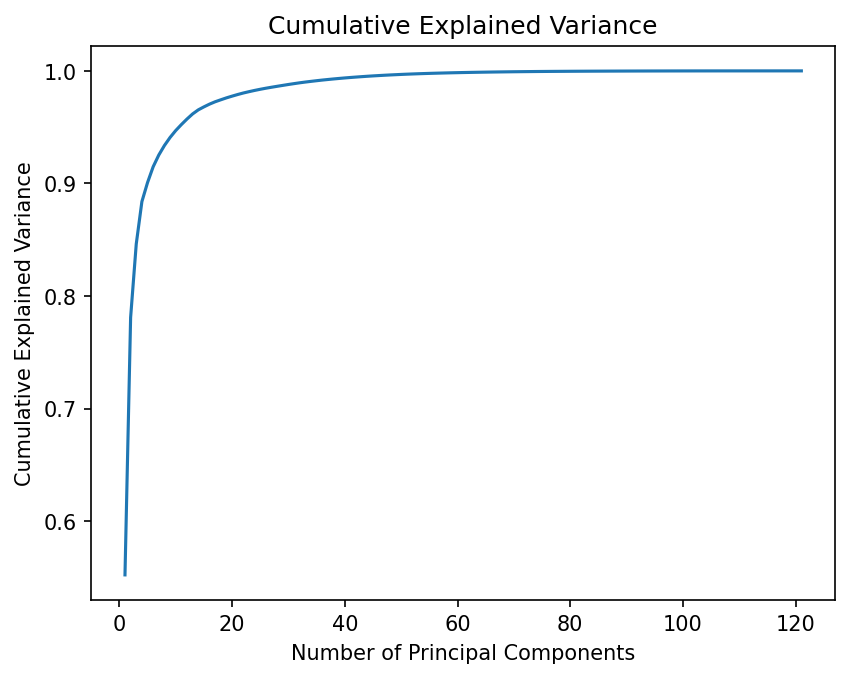

In [364]:
# Perform PCA
pca = PCA(random_state=42)
pca.fit(X)
explained_variance = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance)
fig = plt.figure(dpi=150)
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance)
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

## Split the data into training and testing

In [365]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y, shuffle=True)

## Features selection

### Number of features to select

In [366]:
num_features_to_select = 100

### XGBoost

In [367]:
# Train the XGBoost classifier
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

# Get feature importance scores
importance_scores = model.feature_importances_

# Create a DataFrame to store feature names and their importance scores
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importance_scores})

# Sort features based on importance score in descending order
feature_importances = feature_importances.sort_values(by='Importance', ascending=False).iloc[:num_features_to_select]

# Select top K features based on importance scores
xgboost_top_k_features = feature_importances['Feature'][:num_features_to_select].tolist()

### Select K Best (SKB) IG

In [368]:
# Create an instance of SelectKBest with mutual_info_classif as the scoring function
ig_selector = SelectKBest(score_func=mutual_info_classif, k=num_features_to_select)

# Fit the ig_selector to the data
ig_selector.fit(X, y)

# Get the scores and indices of the selected features
feature_scores = ig_selector.scores_
feature_indices = ig_selector.get_support(indices=True)

# Create a DataFrame to store feature names and their scores
feature_scores_df = pd.DataFrame({'Feature': X.columns, 'Score': feature_scores})

# Sort features based on their scores in descending order
feature_scores_df = feature_scores_df.sort_values(by='Score', ascending=False)

# Select the top K features based on scores
ig_top_k_features = feature_scores_df['Feature'][:num_features_to_select].tolist()

### Select K Best (SKB) ANOVA

In [369]:
# Create an instance of SelectKBest with mutual_info_classif as the scoring function
anova_selector = SelectKBest(score_func=f_classif, k=num_features_to_select)

# Fit the ig_selector to the data
anova_selector.fit(X, y)

# Get the scores and indices of the selected features
feature_scores = ig_selector.scores_
feature_indices = ig_selector.get_support(indices=True)

# Create a DataFrame to store feature names and their scores
feature_scores_df = pd.DataFrame({'Feature': X.columns, 'Score': feature_scores})

# Sort features based on their scores in descending order
feature_scores_df = feature_scores_df.sort_values(by='Score', ascending=False)

# Select the top K features based on scores
anova_top_k_features = feature_scores_df['Feature'][:num_features_to_select].tolist()

### MRMR

In [370]:
mrmr_top_k_features = mrmr_classif(X=X, y=y, K=num_features_to_select)

100%|██████████| 100/100 [00:08<00:00, 11.28it/s]


### RFE Logistic Regression

In [371]:
# Create the estimator (e.g., Logistic Regression)
estimator = LogisticRegression()

# Perform RFE to select top k features
rfe = RFE(estimator, n_features_to_select=num_features_to_select)
X_selected = rfe.fit_transform(X, y)

# Get the indices of the selected features
feature_indices = rfe.get_support(indices=True)

# Get the names of the selected features
rfe_logreg_top_k_features = X.columns[feature_indices].to_list()

In [372]:
np.intersect1d(xgboost_top_k_features, ig_top_k_features)

array(['Adlercreutzia', 'Anaerosalibacter', 'Arabia', 'Bilophila',
       'CAG-988', 'Cardiobacterium', 'Catenibacterium', 'Escherichia',
       'Lactobacillus', 'Lactococcus_A', 'Oscillibacter', 'Porphyromonas',
       'Rahnella', 'Vagococcus'], dtype='<U20')

## Models training / evaluation on XGBoost selected features

In [542]:
# split and upsample minority class in the training set
smote = SMOTE(random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X[anova_top_k_features], y, test_size=0.2, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

### XGBoost

Accuracy: 0.76
Best score: 0.8417989417989418
              precision    recall  f1-score   support

           0       0.78      0.88      0.82        16
           1       0.71      0.56      0.63         9

    accuracy                           0.76        25
   macro avg       0.75      0.72      0.72        25
weighted avg       0.75      0.76      0.75        25

Area under the curve 0.7152777777777778


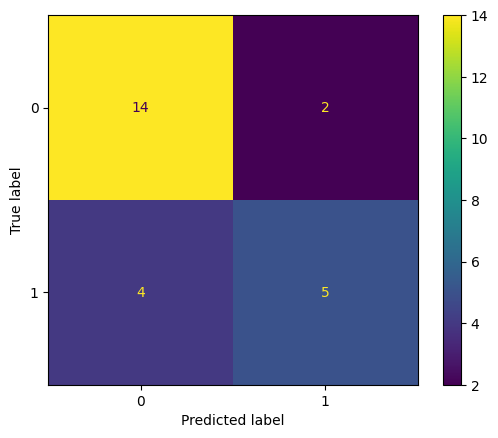

{'xgboost__max_depth': 5,
 'xgboost__max_leaves': 0,
 'xgboost__n_estimators': 100}

In [701]:
# Define the Pipeline
xgboost_pipeline = Pipeline([
  # ('log_transform', FunctionTransformer(np.log1p)),  # Step 1: log transformation
  ('xgboost', xgb.XGBClassifier(random_state=42))  # Step 4: Random Forest
])
xgboost_param_grid = {
  'xgboost__n_estimators': [1, 5, 10, 15, 20, 25, 30, 50, 100, 150, 200],  # Step 4: grid search for n_estimators
  'xgboost__max_depth': [1, 5, 10, 15, 20, 25, 30, 50, 100, 150, 200],  # Step 4: grid search for n_estimators
  'xgboost__max_leaves': [0, 1, 5, 10],  # Step 4: grid search for n_estimators
}

# Define the GridSearchCV object
xgboost_grid_search = GridSearchCV(xgboost_pipeline, param_grid=xgboost_param_grid, cv=5, n_jobs=-1)

# Fit the GridSearchCV object on the training data
xgboost_grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best estimator and make predictions on the testing data
best_estimator = xgboost_grid_search.best_estimator_
y_pred = best_estimator.predict(X_test)

# Compute accuracy for the best found xg
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Best score:", xgboost_grid_search.best_score_)
# Compute accuracy for the best found xg
report = classification_report(y_test, y_pred)
# pd.DataFrame(report).T.to_csv("best_model_xgboost_classification_report.csv", sep=";")
params = xgboost_grid_search.best_params_
# print("Accuracy:", accuracy)
print(report)
print("Area under the curve", roc_auc_score(y_test, y_pred))


cm = confusion_matrix(y_test, y_pred, labels=best_estimator.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=best_estimator.classes_)
disp.plot()
plt.show()
xgboost_grid_search.best_params_

### AdaBoost

Accuracy: 0.68
Best score: 0.8412698412698412
              precision    recall  f1-score   support

           0       0.79      0.69      0.73        16
           1       0.55      0.67      0.60         9

    accuracy                           0.68        25
   macro avg       0.67      0.68      0.67        25
weighted avg       0.70      0.68      0.69        25

Area under the curve 0.6770833333333333


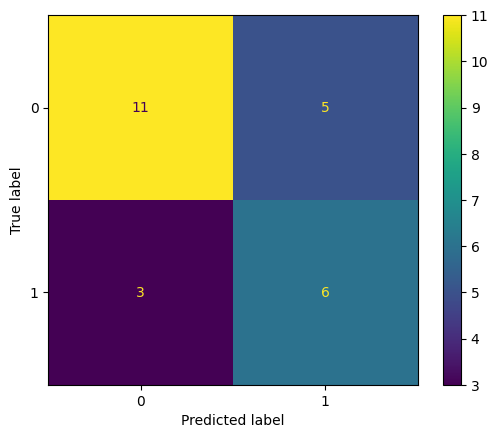

{'adaboost__algorithm': 'SAMME.R',
 'adaboost__learning_rate': 0.7,
 'adaboost__n_estimators': 150}

In [696]:
# Define the Pipeline
ada_pipeline = Pipeline([
    # ('log_transform', FunctionTransformer(np.log1p)),  # Step 1: log transformation
    ('adaboost', AdaBoostClassifier(random_state=42))  # Step 4: Random Forest
])
ada_param_grid = {
    'adaboost__n_estimators': [1, 5, 10, 15, 20, 25, 30, 50, 100, 150, 200],  # Step 4: grid search for n_estimators
    'adaboost__algorithm' :['SAMME', 'SAMME.R'], # Step 4: grid search for criterion
    'adaboost__learning_rate': [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1] # Step 4: grid search for number of max_features
}

# Define the GridSearchCV object
ada_grid_search = GridSearchCV(ada_pipeline, param_grid=ada_param_grid, cv=5, n_jobs=-1)

# Fit the GridSearchCV object on the training data
ada_grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best estimator and make predictions on the testing data
best_estimator = ada_grid_search.best_estimator_
y_pred = best_estimator.predict(X_test)

# Compute accuracy for the best found ada
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Best score:", ada_grid_search.best_score_)
# Compute accuracy for the best found ada
report = classification_report(y_test, y_pred)
# pd.DataFrame(report).T.to_csv("best_model_ada_classification_report.csv", sep=";")
params = ada_grid_search.best_params_
# print("Accuracy:", accuracy)
print(report)
print("Area under the curve", roc_auc_score(y_test, y_pred))


cm = confusion_matrix(y_test, y_pred, labels=best_estimator.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=best_estimator.classes_)
disp.plot()
plt.show()
ada_grid_search.best_params_

### Random Forest

Accuracy: 0.76
Best score: 0.8563492063492063
              precision    recall  f1-score   support

           0       0.81      0.81      0.81        16
           1       0.67      0.67      0.67         9

    accuracy                           0.76        25
   macro avg       0.74      0.74      0.74        25
weighted avg       0.76      0.76      0.76        25

Area under the curve 0.7395833333333333


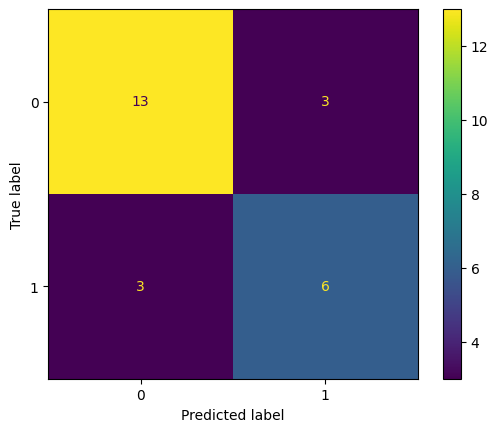

{'rf__criterion': 'entropy',
 'rf__max_depth': 10,
 'rf__max_features': 'sqrt',
 'rf__n_estimators': 10}

In [695]:
# Define the Pipeline
rf_pipeline = Pipeline([
    # ('log_transform', FunctionTransformer(np.log1p)),  # Step 1: log transformation
    ('rf', RandomForestClassifier(random_state=42, warm_start=True))  # Step 4: Random Forest
])
rf_param_grid = {
    'rf__n_estimators': [1, 5, 10, 15, 20, 25],  # Step 4: grid search for n_estimators
    'rf__max_depth': [1, 5, 10, 15, 20, None],  # Step 4: grid search for max_depth
    'rf__criterion' :['gini', 'entropy', 'log_loss'], # Step 4: grid search for criterion
    'rf__max_features': ['sqrt', 'log2'], # Step 4: grid search for number of max_features
}

# Define the GridSearchCV object
rf_grid_search = GridSearchCV(rf_pipeline, param_grid=rf_param_grid, cv=5, n_jobs=-1)

# Fit the GridSearchCV object on the training data
rf_grid_search.fit(X_train_resampled, y_train_resampled)

# Get the best estimator and make predictions on the testing data
best_estimator = rf_grid_search.best_estimator_
y_pred = best_estimator.predict(X_test)

# Compute accuracy for the best found RF
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Best score:", rf_grid_search.best_score_)
# Compute accuracy for the best found RF
report = classification_report(y_test, y_pred)
# pd.DataFrame(report).T.to_csv("best_model_rf_classification_report.csv", sep=";")
params = rf_grid_search.best_params_
# print("Accuracy:", accuracy)
print(report)
print("Area under the curve", roc_auc_score(y_test, y_pred))


cm = confusion_matrix(y_test, y_pred, labels=best_estimator.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=best_estimator.classes_)
disp.plot()
plt.show()
rf_grid_search.best_params_

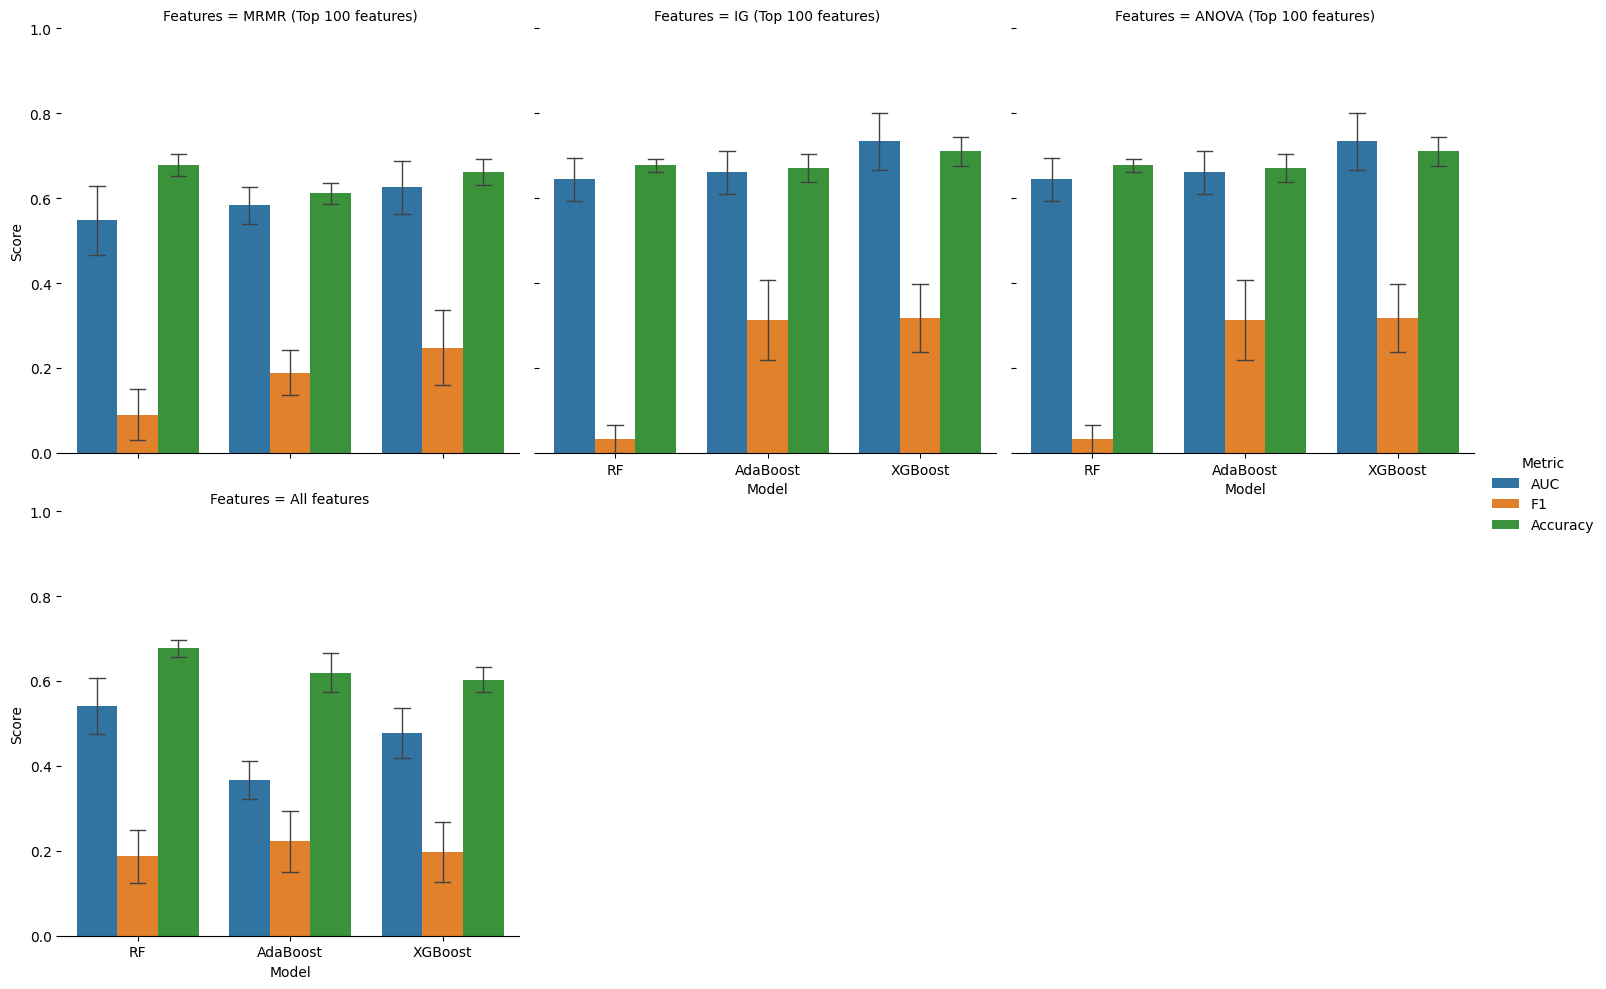

In [744]:
def run_cv_on_estimator(estimator, features, n_cv=10, metrics=('f1', 'accuracy', 'roc_auc')):
    if features == "":
        return cross_validate(estimator, X, y, cv=n_cv, scoring=metrics)
    else:
        return cross_validate(estimator, X[features], y, cv=n_cv, scoring=metrics)
        
    
def plot_metrics(features, estimators, label="", n_cv=10):
    estimator_names = list(estimators.keys())
    df = pd.DataFrame(columns=['Model', 'Metric', 'Score', "Features"])
    for name, estimator in estimators.items():
        for feature_name, feature in features.items():
            tmp_cv_results = run_cv_on_estimator(estimator=estimator, features=feature, n_cv=n_cv)
            for i in range(n_cv):
                df = pd.concat([df, pd.DataFrame([{'Model': name, 'Metric': 'AUC', 'Score': tmp_cv_results['test_roc_auc'][i], 'Features': feature_name}])], ignore_index=True)
                df = pd.concat([df, pd.DataFrame([{'Model': name, 'Metric': 'F1', 'Score': tmp_cv_results['test_f1'][i], 'Features': feature_name}])], ignore_index=True)
                df = pd.concat([df, pd.DataFrame([{'Model': name, 'Metric': 'Accuracy', 'Score': tmp_cv_results['test_accuracy'][i], 'Features': feature_name}])], ignore_index=True)
    g = sns.catplot(
        data=df,
        x='Model',
        y='Score',
        hue='Metric',
        col='Features',
        estimator=np.mean,
        kind='bar',
        errorbar='se',
        capsize=0.1,
        errwidth=1,
        col_wrap=3
        # legend=False,
    )
    g.despine(left=True)
    # g.figure.suptitle(label)
    plt.ylim(0, 1)
    # g.despine(left=True)
    # plt.legend(loc='upper right')

plot_metrics(
    features={
        f"MRMR (Top {num_features_to_select} features)": mrmr_top_k_features,
        f"IG (Top {num_features_to_select} features)": ig_top_k_features,
        f"ANOVA (Top {num_features_to_select} features)": anova_top_k_features,
        f"All features":  ""
    },
    estimators={
        "RF": rf_grid_search.best_estimator_,
        "AdaBoost": ada_grid_search.best_estimator_,
        "XGBoost": xgboost_grid_search.best_estimator_,
    },
    label="MRMR (Top 100 features)",
    n_cv=10
)

In [742]:
X[]

,DUOT01,Murimonas,UBA1174,Eikenella,Senegalimassilia,UMGS1907,UMGS1590,UMGS577,Arabia,MGYG000004171,...,UMGS2070,CAG-831,UMGS1004,Peptacetobacter,UMGS1387,UBA791,MGYG000001812,MGYG000000505,CAG-988,HGM11523
Sample,,,,,,,,,,,,,,,,,,,,,
SRR15595350,7.0,37,2.0,0.0,20136,3.0,1464,254,68,31,...,2.0,249,229,97,545,5.0,1.0,748,54.0,44
SRR15595319,0.0,17,335.0,0.0,8148,9.0,1811,116,32,272,...,1.0,12,44,77,294,0.0,0.0,41,10.0,13
SRR15595315,0.0,63,0.0,0.0,1485,4.0,2355,10,94,41,...,0.0,38,90,87,24,1.0,0.0,20,1.0,8
SRR15595311,0.0,14,4.0,0.0,12114,27.0,1059,23,11,3,...,0.0,13,65,118,91,0.0,3.0,17,1.0,9
SRR15595309,1.0,22,0.0,1.0,89,3.0,426,54,14,5,...,0.0,200,95,32,1,0.0,0.0,2,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR22402326,4.0,129,0.0,0.0,6640,173.0,1861,855,320,451,...,34.0,2091,3654,217,159,1.0,6.0,236,5.0,97
SRR22402325,10.0,685,11.0,38.0,964,47.0,2879,350,123,56,...,22.0,2094,2616,872,101,30.0,54.0,632,47.0,241
SRR22402269,19.0,209,11.0,4.0,2400,68.0,3103,807,124,9706,...,9.0,1982,9079,341,241,3.0,235.0,105,47.0,83
